<a href="https://colab.research.google.com/github/sunandhini96/TSAI_ERAV1/blob/main/Session_13/yolov3_training_resumed_from_checkpoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook yolov3 model training resumed from checkpoints.

# YoloV3 model using pytorch lightning

## YoloV3 :
YOLO-V3 is a feature extractor, called Darknet-53 (it has 52 convolutions) contains skip connections (like ResNet) and 3 prediction heads like Feature Pyramid Network (FPN) — each processing the image at a different spatial compression. In the below architecture output detection blocks 19 x 19, 38 x 38,76 x 76. In first detection block 19 x 19 it detects large objects, in second detection block 38 x 38 it detects medium objects and in third detection block 76 x 76 it detects small objects.

# YoloV3 Architecture :

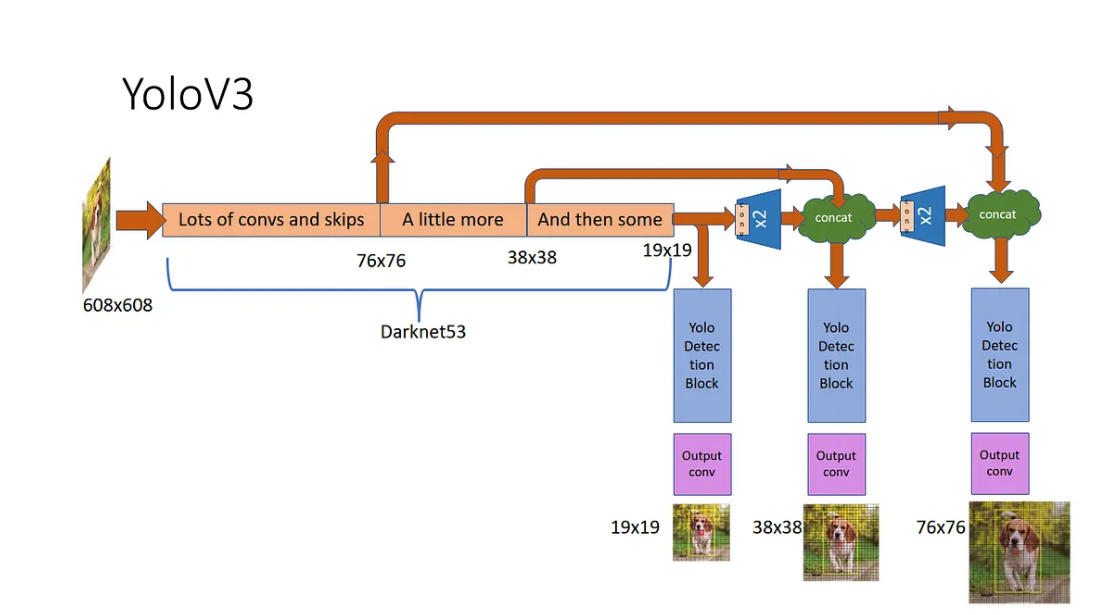

## Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile
# import os

# # Path to the uploaded .zip file on Kaggle
# zip_filepath = '/content/drive/MyDrive/sunandini/dataset.zip'  # Update with the actual path

# # Create a directory to extract the contents of the .zip file
# extract_dir = '/content/drive/MyDrive/sunandini/pascal'
# os.makedirs(extract_dir, exist_ok=True)

# # Extract the contents of the .zip file
# with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print(f"Contents of {zip_filepath} extracted to {extract_dir}")

In [ ]:
# import os

# folder_path = "/content/drive/MyDrive/sunandini/pascal/PASCAL_VOC/labels"  # Replace with the actual path of your folder

# file_count = len(os.listdir(folder_path))
# print(f"Number of files in the folder: {file_count}")

Number of files in the folder: 21503


## Cloning the github repository

In [ ]:
!git clone https://github.com/sunandhini96/ERA_S13.git

Cloning into 'ERA_S13'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 74 (delta 37), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (74/74), 146.33 KiB | 10.45 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [ ]:
#!rm -r /content/drive/MyDrive/sunandini/pascal

In [ ]:
cd "/content/ERA_S13"

/content/ERA_S13


## Installing the required packages

In [ ]:
!pip install pytorch-lightning grad-cam torch_lr_finder gradio


## Importing neceassary packages

In [ ]:

import os
import pytorch_lightning as pl
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.core.display import display
#from pl_bolts.datamodules import CIFAR10DataModule
#from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.functional import accuracy
import torch.cuda.amp as amp
from torch.utils.data import DataLoader
from loss import YoloLoss
from pytorch_lightning import LightningModule, Trainer
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder
import torch.nn as nn
from dataset import YOLODataset

seed_everything(7)



/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/seed.py:39: UserWarning: No seed found, seed set to 2592674027
  rank_zero_warn(f"No seed found, seed set to {seed}")
INFO:lightning_fabric.utilities.seed:Global seed set to 2592674027
INFO:lightning_fabric.utilities.seed:Global seed set to 7


7

In [ ]:
import config
import torch
import torch.optim as optim
import os
from model import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from loss import YoloLoss
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#!rm -r /content/drive/MyDrive/sunandini/Checkpoint/lightning_logs

In [ ]:
PATH_DATASETS = config.DATASET
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 16 if AVAIL_GPUS else 8
AVAIL_GPUS

1

In [ ]:
config.DATASET

'/content/drive/MyDrive/sunandini/pascal/PASCAL_VOC'

## YoloV3 Lightning module

## Training

### In this notebook, we are continuing the training of the model from checkpoints. The model was previously trained for 34 epochs, and a total of 40 epochs are planned. The remaining epochs will be trained in this notebook.



In [ ]:
class YoloVersion3(LightningModule):
    def __init__(self):
        super(YoloVersion3, self).__init__( )
        self.save_hyperparameters()
       # Set our init args as class attributes
        self.learning_rate=config.LEARNING_RATE
        #self.config=config

        self.num_classes=config.NUM_CLASSES
        self.train_csv=config.DATASET + "/train.csv"
        self.test_csv=config.DATASET + "/test.csv"

        self.loss_fn= YoloLoss()
        self.scaler = amp.GradScaler()
        #self.train_transform_function= config.train_transforms
        #self.in_channels = 3
        self.model= YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
        self.scaled_anchors = (
                torch.tensor(config.ANCHORS) * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(config.DEVICE)
        #self.register_buffer("scaled_anchors", self.scaled_anchors)
        self.training_step_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y0, y1, y2 = (
            y[0],
            y[1],
            y[2],
        )
        out = self(x)
        loss = (
                self.loss_fn(out[0], y0, self.scaled_anchors[0])
                + self.loss_fn(out[1], y1, self.scaled_anchors[1])
                + self.loss_fn(out[2], y2, self.scaled_anchors[2])
        )
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)  # Logging the training loss for visualization
        self.training_step_outputs.append(loss)
        return loss

    def on_train_epoch_end(self):

        print(f"\nCurrently epoch {self.current_epoch}")
        train_epoch_average = torch.stack(self.training_step_outputs).mean()
        self.training_step_outputs.clear()
        print(f"Train loss {train_epoch_average}")
        print("On Train Eval loader:")
        print("On Train loader:")
        class_accuracy, no_obj_accuracy, obj_accuracy = check_class_accuracy(self.model, self.train_loader, threshold=config.CONF_THRESHOLD)
        self.log("class_accuracy", class_accuracy, on_epoch=True, prog_bar=True, logger=True)
        self.log("no_obj_accuracy", no_obj_accuracy, on_epoch=True, prog_bar=True, logger=True)
        self.log("obj_accuracy", obj_accuracy, on_epoch=True, prog_bar=True, logger=True)

        if (self.current_epoch>0) and ((self.current_epoch+1) % 6 == 0): # for every 10 epochs we are plotting
            plot_couple_examples(self.model, self.test_loader, 0.6, 0.5, self.scaled_anchors)

        if (self.current_epoch>0) and (self.current_epoch+1 == self.trainer.max_epochs ): #map calculation across last epoch
            check_class_accuracy(self.model, self.test_loader, threshold=config.CONF_THRESHOLD)
            pred_boxes, true_boxes = get_evaluation_bboxes(
                self.test_loader,
                self.model,
                iou_threshold=config.NMS_IOU_THRESH,
                anchors=config.ANCHORS,
                threshold=config.CONF_THRESHOLD,
            )
            mapval = mean_average_precision(
                pred_boxes,
                true_boxes,
                iou_threshold=config.MAP_IOU_THRESH,
                box_format="midpoint",
                num_classes=config.NUM_CLASSES,
            )
            print(f"MAP: {mapval.item()}")

            self.log("MAP", mapval.item(), on_epoch=True, prog_bar=True, logger=True)



    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY,
        )

        # self.trainer.fit_loop.setup_data()
        # dataloader = self.trainer.train_dataloader

        # EPOCHS = config.NUM_EPOCHS # 40 % of number of epochs
        # lr_scheduler = OneCycleLR(
        #     optimizer,
        #     max_lr=1E-3,
        #     steps_per_epoch=len(dataloader),
        #     epochs=EPOCHS,
        #     pct_start=5/EPOCHS,
        #     div_factor=100,
        #     three_phase=False,
        #     final_div_factor=100,
        #     anneal_strategy='linear'
        # )

        # scheduler = {"scheduler": lr_scheduler, "interval" : "step"}

        return [optimizer]

    def setup(self, stage=None):
        self.train_loader, self.test_loader, self.train_eval_loader = get_loaders(
            train_csv_path=self.train_csv,
            test_csv_path=self.test_csv,
        )

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.train_eval_loader

    def test_dataloader(self):
        return self.test_loader
# if __name__ == "__main__":

#     model = YoloVersion3()

#     checkpoint = ModelCheckpoint(filename='last_epoch', save_last=True)
#     lr_rate_monitor = LearningRateMonitor(logging_interval="epoch")
#     trainer = pl.Trainer(
#                   max_epochs=config.NUM_EPOCHS,
#                   deterministic=True,
#                   logger=True,
#                   default_root_dir="/content/drive/MyDrive/sunandini/Checkpoint/",
#                   callbacks=[lr_rate_monitor],
#                   enable_model_summary=False,
#                   log_every_n_steps=1,
#                   precision="16-mixed"
#               )
#     print("---- Training Started ---- Sunandini ----")
#     trainer.fit(model)
#     torch.save(model.state_dict(), 'YOLOv3.pth')

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


---- Training resumed---- sunandini ----


Training: 0it [00:00, ?it/s]


Currently epoch 0
Train loss 3.4840526580810547
On Train Eval loader:
On Train loader:
Class accuracy is: 87.745529%
No obj accuracy is: 98.115395%
Obj accuracy is: 80.098274%

Currently epoch 1
Train loss 3.412980318069458
On Train Eval loader:
On Train loader:
Class accuracy is: 87.914032%
No obj accuracy is: 98.145760%
Obj accuracy is: 80.129013%

Currently epoch 2
Train loss 3.32351016998291
On Train Eval loader:
On Train loader:
Class accuracy is: 88.157471%
No obj accuracy is: 98.087326%
Obj accuracy is: 80.927284%

Currently epoch 3
Train loss 3.3222155570983887
On Train Eval loader:
On Train loader:
Class accuracy is: 88.441589%
No obj accuracy is: 98.121399%
Obj accuracy is: 80.732460%

Currently epoch 4
Train loss 3.3217391967773438
On Train Eval loader:
On Train loader:
Class accuracy is: 88.371780%
No obj accuracy is: 98.149765%
Obj accuracy is: 80.658325%

Currently epoch 5
Train loss 3.2885425090789795
On Train Eval loader:
On Train loader:
Class accuracy is: 88.561569%


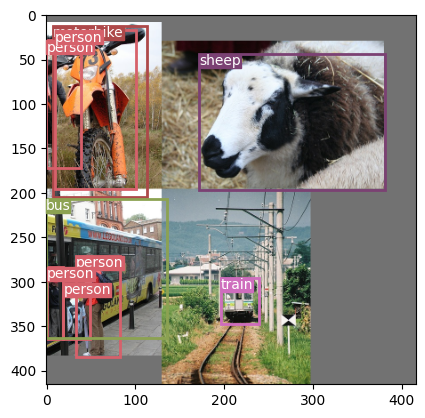

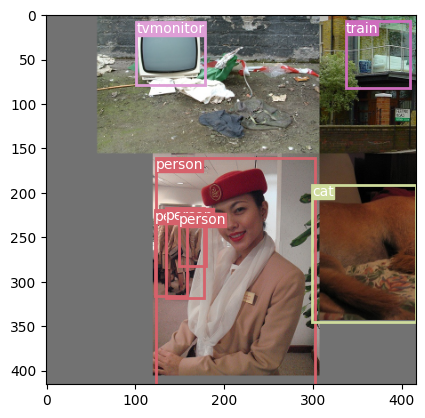

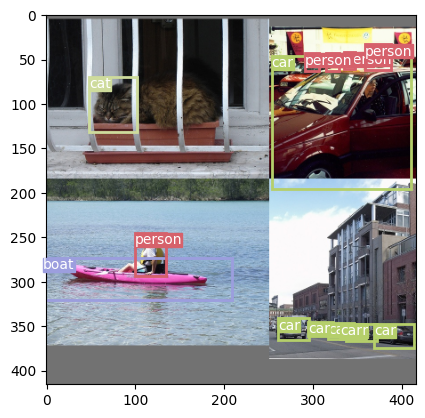

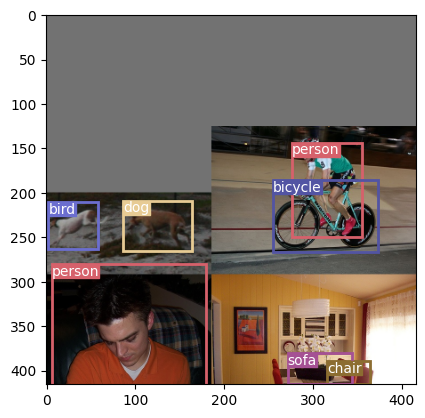

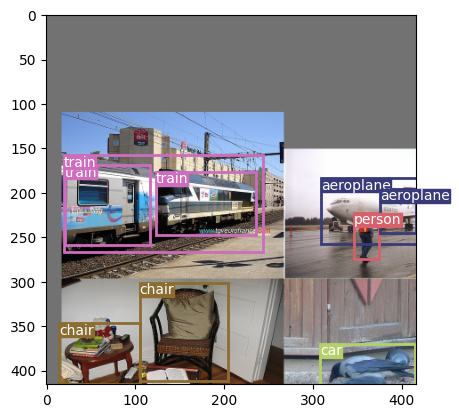

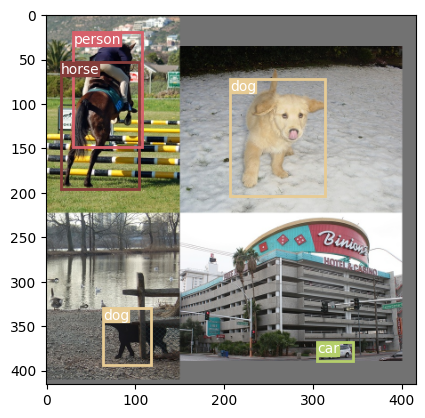

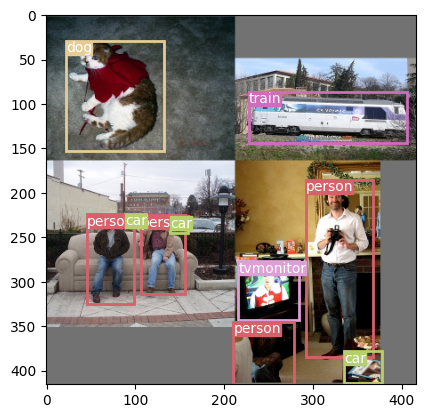

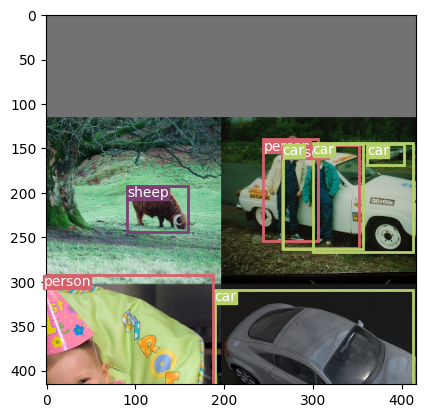

Class accuracy is: 84.539879%
No obj accuracy is: 98.193939%
Obj accuracy is: 76.994972%
MAP: 0.5235162973403931


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [ ]:
checkpoint_path = '/content/drive/MyDrive/sunandini/Checkpoint/lightning_logs/version_3/checkpoints/epoch=33-step=17612.ckpt'
model = YoloVersion3.load_from_checkpoint(checkpoint_path)

checkpoint = ModelCheckpoint(filename='last_epoch', save_last=True)
lr_rate_monitor = LearningRateMonitor(logging_interval="epoch")
trainer = pl.Trainer(
              max_epochs=6,
              deterministic=True,
               logger=True,
              default_root_dir="/content/drive/MyDrive/sunandini/Checkpoint/",
              callbacks=[lr_rate_monitor],
              enable_model_summary=False,
              log_every_n_steps=1,
              precision="16-mixed"
          )
print("---- Training resumed---- sunandini ----")
trainer.fit(model)
torch.save(model.state_dict(), 'YOLOv3.pth')

In [ ]:
# torch.save(model.state_dict(), "model.pth",_use_new_zipfile_serialization=False)

Getting misclassified images

In [ ]:
# from matplotlib import pyplot as plt
# def get_incorrrect_predictions(model, loader, device):
#     """Get all incorrect predictions

#     Args:
#         model (Net): Trained model
#         loader (DataLoader): instance of data loader
#         device (str): Which device to use cuda/cpu

#     Returns:
#         list: list of all incorrect predictions and their corresponding details
#     """
#     model.eval()
#     incorrect = []
#     with torch.no_grad():
#         for data, target in loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             loss = F.cross_entropy(output, target)
#             pred = output.argmax(dim=1)
#             for image, target, pred in zip(data, target, pred):
#                 if pred.eq(target.view_as(pred)).item() == False:
#                     incorrect.append([image.cpu(), target.cpu(), pred.cpu()])

#     return incorrect

# def display_incorrect_images(mismatch, n=20 ):
#     classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#     display_images = mismatch[:n]
#     index = 0
#     fig = plt.figure(figsize=(10,5))
#     for img in display_images:
#         image = img[0].squeeze().to('cpu').numpy()
#         pred = classes[img[2]]
#         actual = classes[img[1]]
#         ax = fig.add_subplot(2, 5, index+1)
#         ax.axis('off')
#         ax.set_title(f'\n Predicted Label : {pred} \n Actual Label : {actual}',fontsize=10)
#         ax.imshow(np.transpose(image, (1, 2, 0)))
#         index = index + 1
#     plt.show()


In [ ]:
# model=YoloVersion3( )
# model.load_state_dict(torch.load("model.pth", map_location=torch.device('cpu')), strict=False)

In [ ]:
# import numpy as np
# model=YoloVersion3( )
# test_dataloader=model.test_dataloader()
# mis_class_images = get_incorrrect_predictions(model, test_dataloader, 'cpu')
# display_incorrect_images(mis_class_images, n=10)